https://www.kaggle.com/datasets/adityajn105/flickr8k/code?select=Images

Let there be color 모델
  - 1.특성을 추출하는 low-level 특징 추출기
  - 2.전체적인 특징을 추출 global level 특징 추출기
  - 3.중간크기의 특징츨 추출mid-level
  - 4.칠해야되는 색을 학습하는 colorization network

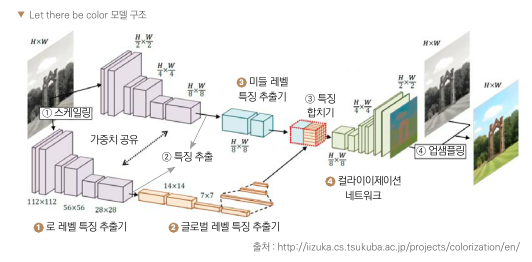

데이터

In [101]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [102]:
# !unzip /content/drive/MyDrive/Flickr8k/Flickr8k.zip -d ./Flickr8k

In [103]:
imgs = glob.glob('/content/Flickr8k/Images/*.jpg')
len(imgs)

8091

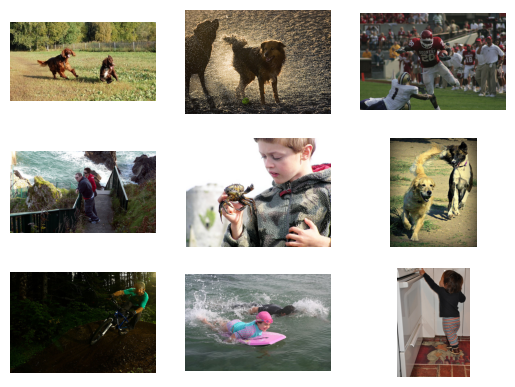

In [104]:
for idx,img in enumerate(imgs[:9]):
  img_ = Image.open(img)
  plt.subplot(3,3,idx+1)
  plt.imshow(img_)
  plt.axis('off')
plt.show()

학습용 데이터 만들기
  - RGB 이미지
  - LAB 이미지를 이용해서 학습
    - 밝기, A(녹색,적색), B(청색,노란색) 두가지 색
  - RGB - LAB 전처리
  - cvtColor()

RGB -> LAB

In [105]:
import cv2
import numpy as np
from torch.utils.data.dataset import Dataset
def rgb2lab(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
def lab2rgb(lab):
  return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [106]:
class AutoColoring(Dataset):
  def __init__(self):
    self.data = glob.glob('/content/Flickr8k/Images/*.jpg')
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    rgb = np.array(Image.open(self.data[index]).resize((256,256)))
    # 변환
    lab = rgb2lab(rgb)
    # 채널 차원이 앞에 오도록 shape변경
    lab = lab.transpose(2,0,1).astype(np.float32)
    # 모델입력으로 흑백이미지 L채널이 입력, AB가 정답
    return lab[0], lab[1:]

In [107]:
temp = np.array(Image.open(imgs[0]).resize((256,256)))
temp.shape

(256, 256, 3)

In [108]:
temp.transpose((2,0,1)).shape

(3, 256, 256)

모델정의
  - low lebel
  - 작은 특징을 추출

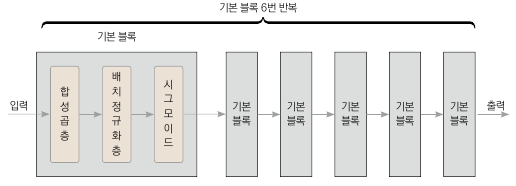

In [109]:
import torch
import torch.nn as nn

class LowLevel(nn.Module):
  def __init__(self):
    super(LowLevel,self).__init__()

    self.low1 = nn.Conv2d(1,64,kernel_size=3,stride=2,padding=1)
    self.lb1 = nn.BatchNorm2d(64)
    self.low2 = nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.lb2 = nn.BatchNorm2d(128)
    self.low3 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1)
    self.lb3 = nn.BatchNorm2d(128)
    self.low4 = nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.lb4 = nn.BatchNorm2d(256)
    self.low5 = nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1)
    self.lb5 = nn.BatchNorm2d(256)
    self.low6 = nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
    self.lb6 = nn.BatchNorm2d(512)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    #기본블럭
    low = self.low1(x)
    low = self.lb1(low)
    low = self.sigmoid(low)

    low = self.low2(low)
    low = self.lb2(low)
    low = self.sigmoid(low)

    low = self.low3(low)
    low = self.lb3(low)
    low = self.sigmoid(low)

    low = self.low4(low)
    low = self.lb4(low)
    low = self.sigmoid(low)

    low = self.low5(low)
    low = self.lb5(low)
    low = self.sigmoid(low)

    low = self.low6(low)
    low = self.lb6(low)
    low = self.sigmoid(low)

    return low

미들 레벨 특징 추출기
  - 이미지의 중간크기의 특징 추출
  - 이미지의 크기가 변화면 안됨
  - 스트라이드와 패딩에 주의  
    - 커널이 3이면 스트라이드와 패딩을 1로주면 이미지 크기가 변경안됨  

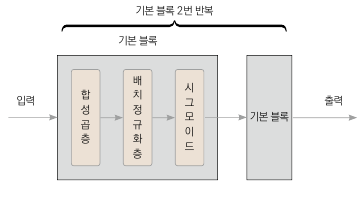

In [110]:
import torch
import torch.nn as nn

class MidLevel(nn.Module):
  def __init__(self):
    super(MidLevel,self).__init__()

    self.mid1 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.mb1 = nn.BatchNorm2d(512)
    self.mid2 = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    self.mb2 = nn.BatchNorm2d(256)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    #기본블럭
    mid = self.mid1(x)
    mid = self.mb1(mid)
    mid = self.sigmoid(mid)

    mid = self.mid2(mid)
    mid = self.mb2(mid)
    mid = self.sigmoid(mid)

    return mid

글로벌 레벨 특징 추출기
  - 마지막에  평탄화 + MLP층

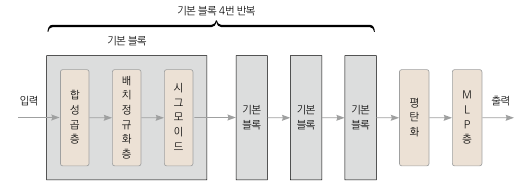

In [111]:
import torch
import torch.nn as nn

class GlobalLevel(nn.Module):
  def __init__(self):
    super(GlobalLevel,self).__init__()

    self.glob1 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.gb1 = nn.BatchNorm2d(512)
    self.glob2 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.gb2 = nn.BatchNorm2d(512)
    self.glob3 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.gb3 = nn.BatchNorm2d(512)
    self.glob4 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.gb4 = nn.BatchNorm2d(512)
    self.sigmoid = nn.Sigmoid()

    # MLP 구성
    # 색을 칠하기위해 사용하는 특징
    self.fc1 = nn.Linear(in_features=32768, out_features = 1024)
    self.fc2 = nn.Linear(in_features=1024, out_features = 512)
    self.fc3 = nn.Linear(in_features=512, out_features = 256)



  def forward(self,x):
    #기본블럭
    glo = self.glob1(x)
    glo = self.gb1(glo)
    glo = self.sigmoid(glo)
    glo = self.glob2(glo)
    glo = self.gb2(glo)
    glo = self.sigmoid(glo)
    glo = self.glob3(glo)
    glo = self.gb3(glo)
    glo = self.sigmoid(glo)
    glo = self.glob4(glo)
    glo = self.gb4(glo)
    glo = self.sigmoid(glo)

    glo = torch.flatten(glo,start_dim=1)
    glo = self.fc1(glo)
    glo = self.sigmoid(glo)
    glo = self.fc2(glo)
    glo = self.sigmoid(glo)
    glo = self.fc3(glo)
    glo = self.sigmoid(glo)
    return glo

colorization network

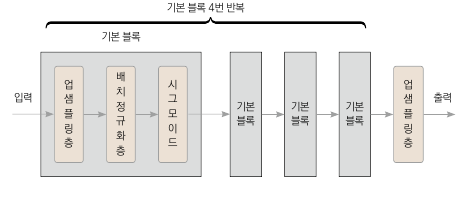

In [112]:
import torch
import torch.nn as nn

class Colorization(nn.Module):
  def __init__(self):
    super(Colorization,self).__init__()
    # 업셈플링의 출력이미지 크기
    #(size-1)*stride-2*padding+(kernel-1)+1
    # 32픽셀이라고하면 1번에 대입하면
    # (32-1)*1-2*1+(3-1)+1 = 32
    # (32-1)*2-2*0+(2-1)+1 = 31*2+2 = 64

    # 1
    self.color1 = nn.ConvTranspose2d(256,128,3,1,1)
    self.cb1 = nn.BatchNorm2d(128)
    # 2
    self.color2 = nn.ConvTranspose2d(128,64,2,2)
    self.cb2 = nn.BatchNorm2d(64)

    self.color3 = nn.ConvTranspose2d(64,64,3,1,1)
    self.cb3 = nn.BatchNorm2d(64)

    self.color4 = nn.ConvTranspose2d(64,32,2,2)
    self.cb4 = nn.BatchNorm2d(32)

    self.color5 = nn.ConvTranspose2d(32,2,2,2)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    #기본블럭
    color = self.color1(x)
    color = self.cb1(color)
    color = self.sigmoid(color)

    color = self.color2(color)
    color = self.cb2(color)
    color = self.sigmoid(color)
    color = self.color3(color)
    color = self.cb3(color)
    color = self.sigmoid(color)
    color = self.color4(color)
    color = self.cb4(color)
    color = self.sigmoid(color)
    color = self.color5(color)
    return color

전체 모델 정의

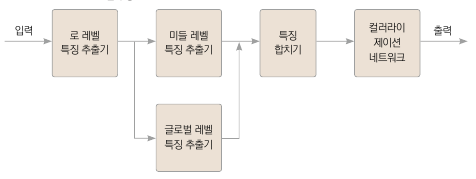

In [113]:
class AutoColoringModel(nn.Module):
  def __init__(self):
    super(AutoColoringModel,self).__init__()

    self.low = LowLevel()
    self.mid = MidLevel()
    self.glob = GlobalLevel()

    # 특징 합치기
    self.fusino = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)

    # 색 입히기
    self.color = Colorization()
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    # 1
    low = self.low(x)
    mid = self.mid(low)
    glo = self.glob(low)

    # 2. 글로벌 레벨 특징 추출기의 출력을 미들 레벨특징 추출기의 출력 크기가 되도록 반복
    fusion = glo.repeat(1,mid.shape[2]*mid.shape[2])
    fusion = torch.reshape(
        fusion, (-1,256,mid.shape[2],mid.shape[2])
    )

    # 3. 글로벌 레벨 미들 레벨의 특징 결합
    fusion = torch.cat([mid,fusion],dim=1)
    fusion = self.fusino(fusion)
    fusion = self.sigmoid(fusion)

    # 4. 컬러라이제이션 신경망
    color = self.color(fusion)
    return color


1 로레벨,미들,글로벌 특징을 합쳐줘야함

글로벌은 미들의 출력값에 각 픽셀의 값을 합쳐줘야함

중간크기를 고려해서 전체적인 이미지를 고려하기위해서



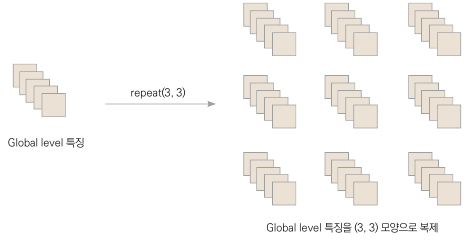

미들레벨에서 글로벌 레벨특징을 참고하기위해서 글로벌을 미들크기로 복사해서 맞춰줌

모델정의

In [114]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else 'cpu'
model = AutoColoringModel().to(device)

In [115]:
dataset = AutoColoring()
loader = DataLoader(dataset,batch_size=32,shuffle=True)
optim = Adam(model.parameters(),lr=1e-2)

In [127]:
for epoch in range(20):
  iterdata = tqdm.tqdm(loader)
  for L, AB in iterdata:
    # L은 흑백이미지 채널확보
    L = torch.unsqueeze(L,dim=1).to(device)
    optim.zero_grad()
    pred = model(L)
    loss = nn.MSELoss()(pred,AB.to(device))
    loss.backward()
    optim.step()
    iterdata.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),'AutoColor.pth')

epoch:21 loss:199.1050567626953:   9%|▊         | 22/253 [00:16<02:51,  1.34it/s]


KeyboardInterrupt: ignored

In [ ]:
import numpy as np

test_L, test_AB =  dataset[10]
test_L = np.expand_dims(test_L,axis=0)
real_img = np.concatenate([test_L,test_AB])
real_img = real_img.transpose(1,2,0).astype(np.uint8)
real_img = lab2rgb(real_img)

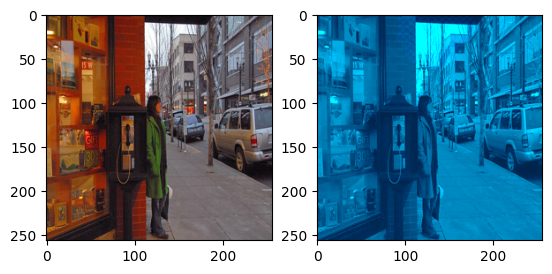

In [126]:
with torch.no_grad():
  model.load_state_dict(torch.load('AutoColor.pth',map_location=device))

  # 모델 값 예측
  input_tensor = torch.tensor(test_L)
  input_tensor = torch.unsqueeze(input_tensor,dim=0).to(device)
  pred_AB = model(input_tensor)

  # 그리기 위해서 변형
  pred_LAB = torch.cat([input_tensor,pred_AB],dim=1)
  pred_LAB = torch.squeeze(pred_LAB)
  pred_LAB = pred_LAB.permute(1,2,0).cpu().numpy()
  pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

plt.subplot(1,2,1)
plt.imshow(real_img)
plt.subplot(1,2,2)
plt.imshow(pred_LAB)